In [12]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

from utils import *
from tqdm.auto import tqdm
import numpy as np
import pickle
import os
from model import probability_weighting

from experiment import unpack_and_dequantize

from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

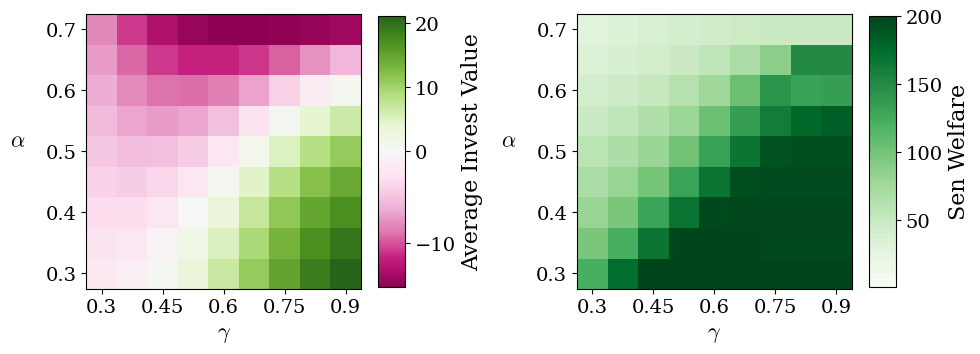

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

alpha_vals = np.linspace(0.3, 0.7, 9)
gamma_vals = np.linspace(0.3, 0.9, 9)

# --- PLOT 1: Invest Value ---
avg_invest_val = np.zeros((9, 9))
for f in os.listdir("../gamma_alpha"):
    a, g = f.split("_")[:2]
    # Check if file matches our linspace values to avoid index errors
    if float(a) in alpha_vals and float(g) in gamma_vals:
        a_idx = np.argmin(np.abs(alpha_vals - float(a)))
        g_idx = np.argmin(np.abs(gamma_vals - float(g)))
        
        with open("../gamma_alpha/" + f, "rb") as file:
            data = pickle.load(file)
        inv = np.where(data["invest_val"] == -np.inf, -50, data["invest_val"])
        avg_invest_val[a_idx, g_idx] = np.mean(inv)

norm = TwoSlopeNorm(vcenter=0, vmin=avg_invest_val.min(), vmax=avg_invest_val.max())

# Alpha on Y-axis (rows), Gamma on X-axis (cols) -> No transpose needed
im1 = axs[0].imshow(avg_invest_val, origin="lower", cmap="PiYG", norm=norm)

axs[0].set_xlabel(r"$\gamma$")
axs[0].set_ylabel(r"$\alpha$", rotation=0, labelpad=20)
axs[0].set_xticks([0, 2, 4, 6, 8], [0.3, 0.45, 0.6, 0.75, 0.9])
axs[0].set_yticks([0, 2, 4, 6, 8], [0.3, 0.4, 0.5, 0.6, 0.7])

cbar1 = fig.colorbar(im1, ax=axs[0], shrink=0.6, aspect=10, label="Average Invest Value")

# --- PLOT 2: Welfare ---
welfare = np.zeros((9, 9))
for f in os.listdir("../gamma_alpha"):
    a, g = f.split("_")[:2]
    if float(a) in alpha_vals and float(g) in gamma_vals:
        a_idx = np.argmin(np.abs(alpha_vals - float(a)))
        g_idx = np.argmin(np.abs(gamma_vals - float(g)))
        
        with open("../gamma_alpha/" + f, "rb") as file:
            data = pickle.load(file)
        
        # Calculate welfare
        welfare[a_idx, g_idx] = sen_welfare(
            utility(
                unpack_and_dequantize(data["wealth"][:, -1], 200),
                unpack_and_dequantize(data["health"][:, -1], 200),
                alpha=float(a)
            )
        )

# Added vmin=1 and vmax=200 here
im2 = axs[1].imshow(welfare, origin="lower", cmap="Greens", vmin=1, vmax=200)

axs[1].set_xlabel(r"$\gamma$")
axs[1].set_ylabel(r"$\alpha$", rotation=0, labelpad=20)
axs[1].set_xticks([0, 2, 4, 6, 8], [0.3, 0.45, 0.6, 0.75, 0.9])
axs[1].set_yticks([0, 2, 4, 6, 8], [0.3, 0.4, 0.5, 0.6, 0.7])

cbar2 = fig.colorbar(im2, ax=axs[1], shrink=0.6, aspect=10, label="Sen Welfare")

fig.tight_layout()
plt.savefig("../figures/gamma_alpha.pdf", bbox_inches="tight")
plt.show()